In [1]:
import sys
sys.path.append('..')

from data_parsers import databento_file_parser
from executor import SimpleExecutor1
from itertools import product

import pandas as pd
import math
import numpy as np

from tqdm import tqdm
import math
import numpy
import matplotlib.pyplot as plt
import random
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 80)

## 1 - 2  Avellaneda and Stoikov Model

In [2]:
# Marco Avellaneda & Sasha Stoikov

''' 
This algo give bid and ask quote based on the Sasha Stoikov and Marco Avellaneda Model

Input:
- mid_price = current mid price
- sigma = market volatility    
- q = current position    
- time_frac = fraction of trading day elapsed
- gamma = 0.1, risk aversion parameter
- k = 1.5, Market model parameter
'''

def quote_stoikov_avellaneda_a(mid_price, sigma, q, time_frac, gamma = 0.1, k = 0.1):
    
    # Option A: limit time horizon
    # Reserve price
    r = mid_price - q * gamma * sigma**2 * time_frac

    # Reserve spread
    r_spread = 2 / gamma * np.log(1+gamma/k)

    # optimal quotes
    ra = r + r_spread/2
    rb = r - r_spread/2

    ra = ra.round(2)
    rb = rb.round(2)

    return rb, ra

quote_stoikov_avellaneda_a(10, 0.05, 100, 1, gamma = 0.1, k = 40)

(9.95, 10.0)

In [3]:
params = {'MSFT': {'gamma': 0.1, 'k': 30}, 
          'AMZN': {'gamma': 0.1, 'k': 35}, 
          'NVDA': {'gamma': 0.1, 'k': 35}, 
         }

class BOT1(SimpleExecutor1):

    def calculate_bid_ask_price(self, bid_orderbook, ask_orderbook, inventory):
        """
        Compute the bid and ask prices based on orderbook status and inventory
        Needs to be overwritten by the model
        """
        mid_price = (ask_orderbook[0][0] + bid_orderbook[0][0])/2
        bid, ask = quote_stoikov_avellaneda_a(mid_price, self.sigma_1min, inventory, 
                                              self.time_frac_elapsed, 
                                              gamma=params[self.ticker]['gamma'], k=params[self.ticker]['k'])
        if self.is_verbose_cnt():
            print(f"{mid_price=} {bid=} {ask=} {self.sigma_1min=:.4f} {self.time_frac_elapsed=:.4f}")

        return bid, ask

model_name = 'avellaneda'

In [4]:
# TRAIN_DATES = ['20230515', '20230516']
# TEST_DATES = ['20230517', '20230518', '20230519']

TICKERS = ['AMZN', 'MSFT', 'NVDA']
TEST_DATES = ['20230515', '20230516', '20230517', '20230518', '20230519']
# TEST_DATES = ['20230515']

LATENCY = [0, 5, 10]

TEST_SAMPLE = list(product(TICKERS, TEST_DATES))
TEST_SAMPLE

[('AMZN', '20230515'),
 ('AMZN', '20230516'),
 ('AMZN', '20230517'),
 ('AMZN', '20230518'),
 ('AMZN', '20230519'),
 ('MSFT', '20230515'),
 ('MSFT', '20230516'),
 ('MSFT', '20230517'),
 ('MSFT', '20230518'),
 ('MSFT', '20230519'),
 ('NVDA', '20230515'),
 ('NVDA', '20230516'),
 ('NVDA', '20230517'),
 ('NVDA', '20230518'),
 ('NVDA', '20230519')]

In [5]:
output = {}
for latency in LATENCY:
    for ticker, date in TEST_SAMPLE:
        data_file_path = f'../data/databento/{ticker}/xnas-itch-{date}.mbp-10.dbn.zst'
        data_df = databento_file_parser(data_file_path)
        print(f"\n*** Starting for {ticker=}, {date=}, {latency=} ***")
        print(len(data_df))
        for start_ts, group_df in data_df.resample('30min'):
            print(start_ts, len(group_df))
            bot1 = BOT1(ticker=ticker, latency=latency)
            bot1.run_sim(group_df)
            output[(ticker, latency, start_ts)] = bot1.output_data


*** Starting for ticker='AMZN', date='20230515', latency=0 ***
1602775
2023-05-15 14:00:00 208799
mid_price=110.035 bid=nan ask=nan self.sigma_1min=nan self.time_frac_elapsed=0.0000
capital=-4695.9299999999785 position=42 pnl=-46.6499999999781 trading_pnl=60.515000000002736 trading_volume=3768 avg_size=19.477600591783048 avg_size_square=700.3755216713804
2023-05-15 14:30:00 155829
mid_price=109.805 bid=nan ask=nan self.sigma_1min=nan self.time_frac_elapsed=0.0000
capital=-1998.699999999997 position=18 pnl=14.190000000002748 trading_pnl=59.36500000000127 trading_volume=3496 avg_size=16.7133767550163 avg_size_square=573.0571344961835
2023-05-15 15:00:00 128587
mid_price=109.875 bid=nan ask=nan self.sigma_1min=nan self.time_frac_elapsed=0.0000
capital=2654.8200000000033 position=-25 pnl=-85.4699999999971 trading_pnl=33.91000000000023 trading_volume=2271 avg_size=14.718744760813967 avg_size_square=422.5179762195137
2023-05-15 15:30:00 142390
mid_price=110.525 bid=nan ask=nan self.sigma_1m

In [6]:
out_df = pd.DataFrame(output).T.reset_index()
del out_df['trades']
del out_df['quotes']

out_df.columns = ['ticker', 'latency', 'start_ts'] + list(out_df.columns)[3:]
out_df['utility'] = 100 * (out_df['net_pnl'] + 2 * out_df['trading_pnl'] - 0.01 * out_df['avg_size_square']) / out_df['trading_volume']

print(out_df.groupby(['ticker', 'latency']).mean())
print(out_df.groupby(['ticker', 'latency']).std())

out_df.to_csv(f'backtest_output_{model_name}.csv')
out_df

                                    start_ts eod_position     eod_cash  \
ticker latency                                                           
AMZN   0       2023-05-17 16:44:59.999999744    10.383333   -1166.4835   
       5       2023-05-17 16:44:59.999999744          7.2  -798.705333   
       10      2023-05-17 16:44:59.999999744        -1.55   190.732667   
MSFT   0       2023-05-17 16:44:59.999999744     1.366667  -414.591833   
       5       2023-05-17 16:44:59.999999744     4.283333 -1362.301667   
       10      2023-05-17 16:44:59.999999744        -3.25   993.900333   
NVDA   0       2023-05-17 16:44:59.999999744   -10.283333  3225.613333   
       5       2023-05-17 16:44:59.999999744    -1.066667   306.596333   
       10      2023-05-17 16:44:59.999999744    -2.216667   547.134667   

                  net_pnl trading_pnl   avg_size avg_size_square  \
ticker latency                                                     
AMZN   0          15.5345   51.882083   14.14808 

,ticker,latency,start_ts,eod_position,eod_cash,net_pnl,trading_pnl,avg_size,avg_size_square,trading_volume,volatility,net_return,utility
0,AMZN,0,2023-05-15 14:00:00,42,-4695.93,-46.65,60.515,19.477601,700.375522,3768,0.042363,0.295,1.788117
1,AMZN,0,2023-05-15 14:30:00,18,-1998.7,14.19,59.365,16.713377,573.057134,3496,0.033384,-0.07,3.638142
2,AMZN,0,2023-05-15 15:00:00,-25,2654.82,-85.47,33.91,14.718745,422.517976,2271,0.024774,-0.67,-0.96324
3,AMZN,0,2023-05-15 15:30:00,-22,2426.82,18.97,39.46,16.381142,523.276166,2282,0.024531,0.06,4.060352
4,AMZN,0,2023-05-15 16:00:00,152,-16823.23,-86.05,24.46,10.880474,387.175248,1186,0.019413,0.49,-3.457146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,NVDA,10,2023-05-19 17:30:00,47,-14676.24,19.785,69.055,3.429262,44.46859,2239,0.064872,0.92,7.032171
536,NVDA,10,2023-05-19 18:00:00,40,-12603.72,-83.44,97.435,4.299099,47.151845,3068,0.065834,0.0,3.616639
537,NVDA,10,2023-05-19 18:30:00,-89,27843.68,10.88,61.965,2.868681,39.615711,2331,0.061751,-0.76,5.76636
538,NVDA,10,2023-05-19 19:00:00,-4,1220.32,0.98,80.075,2.968319,24.295037,3134,0.053526,0.35,5.133601


In [7]:
trades_df = [] 
quotes_df = []

for key in output:
    o = output[key]
    df = o['trades']
    df['ticker'] = key[0]
    df['latency'] = key[1]
    df['start_ts'] = key[2]
    trades_df.append(df)

    df = o['quotes']
    df['ticker'] = key[0]
    df['latency'] = key[1]
    df['start_ts'] = key[2]
    quotes_df.append(df)

trades_df = pd.concat(trades_df)
quotes_df = pd.concat(quotes_df)
    
trades_df.to_csv(f'backtest_output_{model_name}_trades.csv')
quotes_df.to_csv(f'backtest_output_{model_name}_quotes.csv')

# Plots

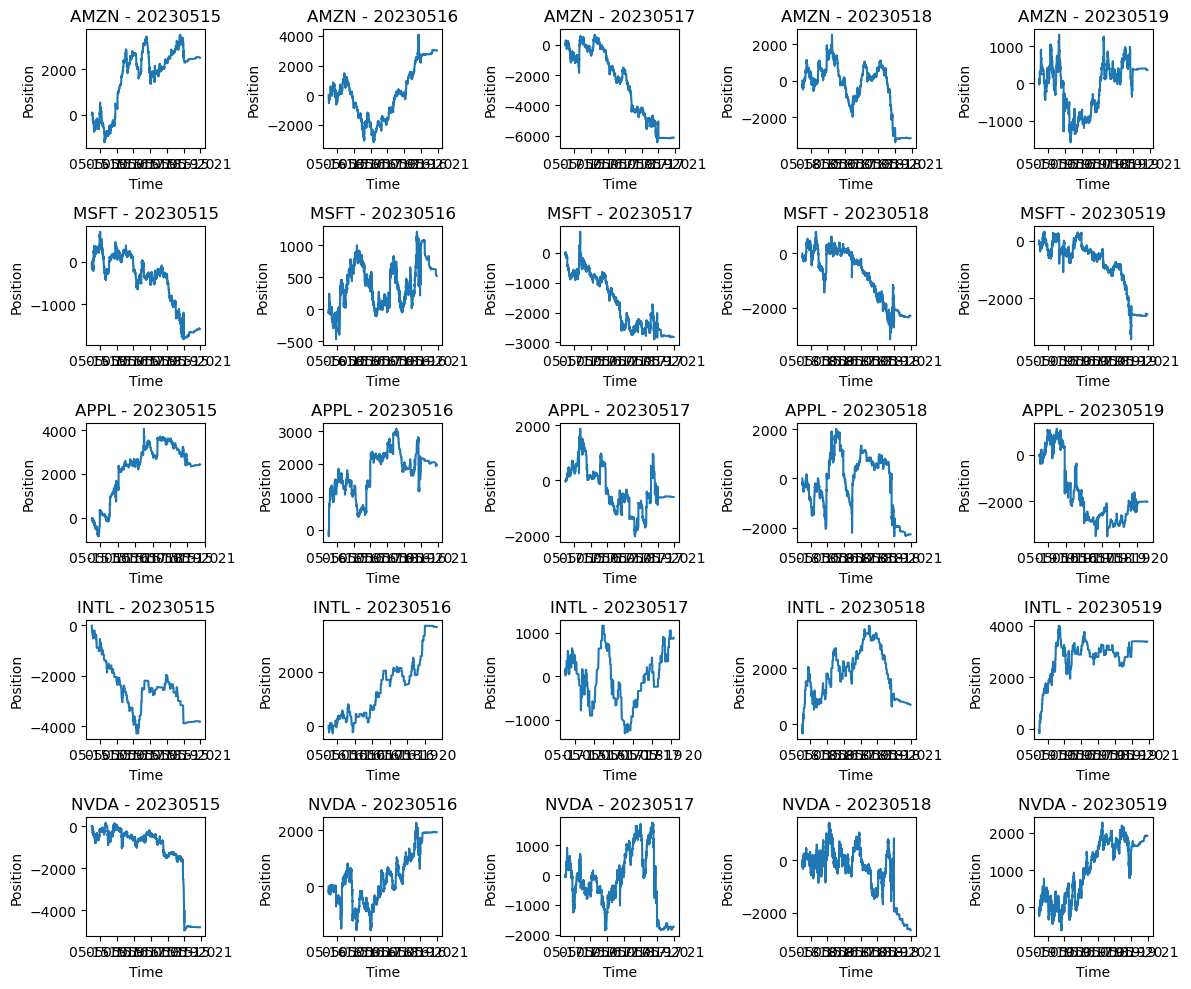

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a 3x3 grid of plots
fig, axes = plt.subplots(5, 5, figsize=(12, 10))

# Iterate over DataFrames and labels and plot positions
for label, ax in zip(TEST_SAMPLE, axes.flatten()):
    df = output[label]['trades']
    ax.plot(df['ts'], df['size'].cumsum())
    ax.set_title(f"{label[0]} - {label[1]}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Position')

# Adjust layout
plt.tight_layout()
plt.show()

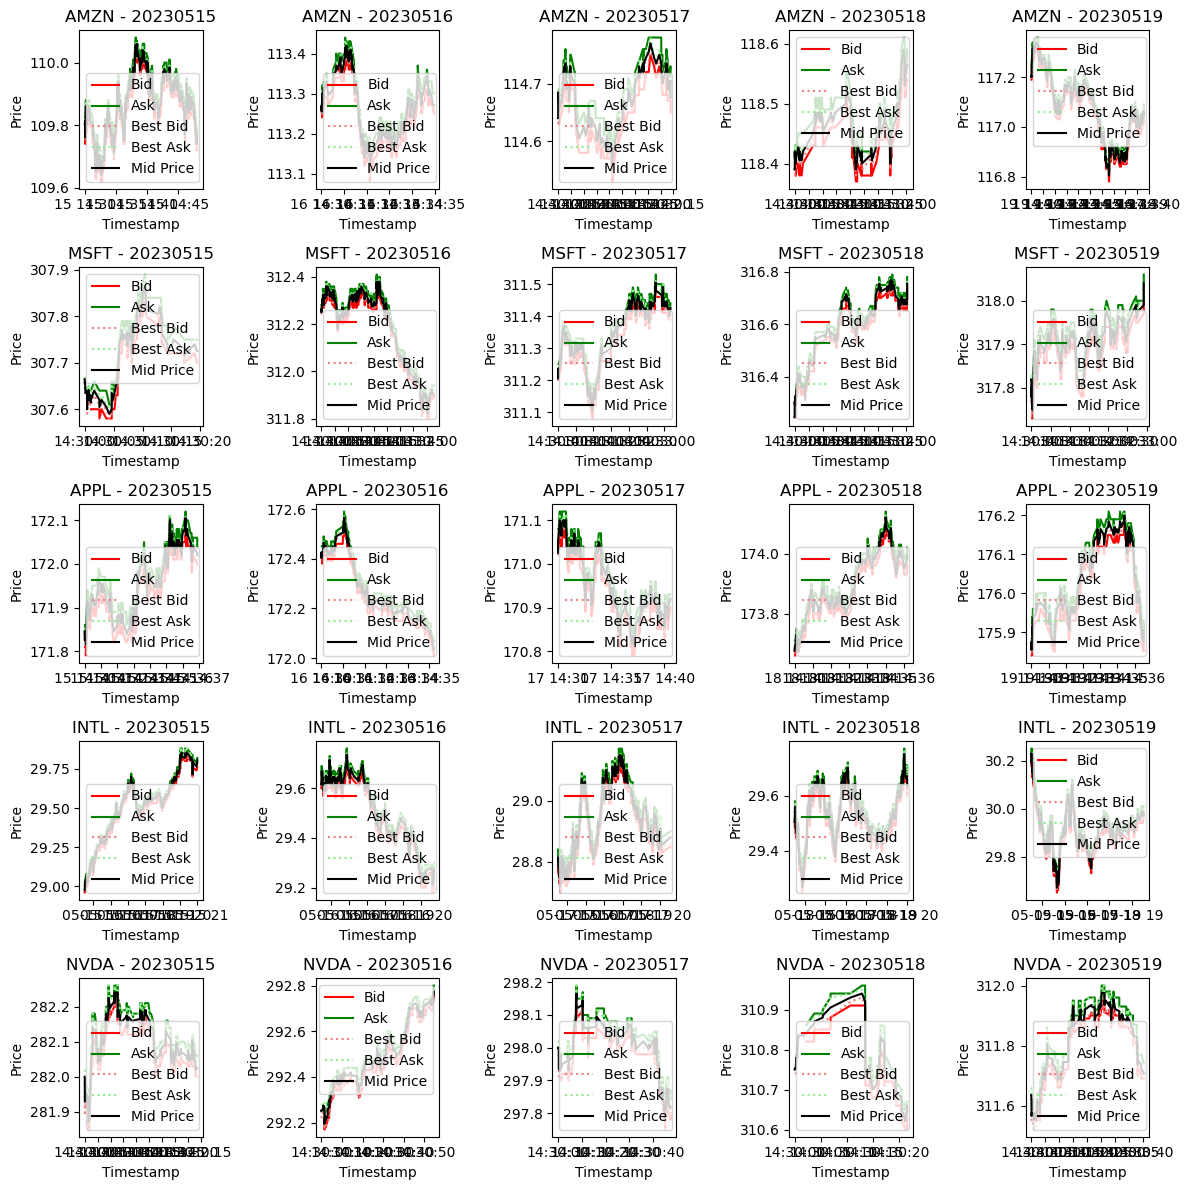

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for label, ax in zip(TEST_SAMPLE, axes.flatten()):
    df = output[label]['quotes']
    df['mid_price'] = (df['best_bid'] + df['best_ask'])/2
    
    df = df.iloc[:500].ffill()
    ax.plot(df['ts'], df['bid'], color='red', label='Bid')
    ax.plot(df['ts'], df['ask'], color='green', label='Ask')
    ax.plot(df['ts'], df['best_bid'], linestyle=':', color='lightcoral', label='Best Bid')
    ax.plot(df['ts'], df['best_ask'], linestyle=':', color='lightgreen', label='Best Ask')
    ax.plot(df['ts'], df['mid_price'], color='black', label='Mid Price')    
    ax.set_title(f"{label[0]} - {label[1]}")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Price')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [10]:
def create_value_tbl(name):
    
    tbl = list()
    for ticker, date in TEST_SAMPLE:
        tbl.append({'ticker': ticker, 'date': date, name: output[(ticker, date)][name]})
        
    tbl = pd.DataFrame(tbl)
    return tbl


for col in ['net_pnl', 'trading_pnl', 'average_inventory']:
    print(f'{col} Table')
    print(create_value_tbl(col).pivot(columns='date', index='ticker', values=col))


net_pnl Table
date    20230515  20230516  20230517  20230518  20230519
ticker                                                  
AMZN     2636.12    993.26    856.85   -117.07   1613.34
APPL      142.30    599.86   1298.12    397.27   3002.37
INTL    -1246.21   -484.11    242.83    675.93    229.45
MSFT     -373.68  -1015.67  -1826.84  -3163.13   2340.82
NVDA    -1262.34  -2923.28   -321.15  -4544.84    346.36
trading_pnl Table
date    20230515  20230516  20230517  20230518  20230519
ticker                                                  
AMZN     335.295   477.495   465.885   536.440   459.185
APPL     306.970   314.740   572.200   654.845   661.070
INTL      92.300    78.575   122.130   150.055   151.920
MSFT     441.415   536.885   709.490  1085.115   838.795
NVDA     807.205  1669.690  1638.625  3494.440  2137.685
average_inventory Table
date     20230515   20230516   20230517   20230518   20230519
ticker                                                       
AMZN    13.107583  14.